# Multilayer Perceptron

One layer perceptron is a linear transformation of inputs to output. If our data could be approximated linearly, one layer should be enough. But linearity is a *strong assumption*. Any change in input could drive the output up or down. To many application, this is not true.

## Hidden Layers

In linear regression and softmax regression, we mapped our inputs directly to our outputs via a single linear transformation

$$ \hat{o} = \text{softmax}(Wx + b) $$

Single layout perceptron with 5 output units

![onelayer](singlelayer.svg)

If our data are not linear and each feature has different importance, we cannot simulate our data just by linear transformation. This is when we need another hidden layer for computation

![onelayer](mlp.svg)

The mathematical for MLP would be

$$ 
\begin{align}
h &= \sigma(W_1 x + b_1) \\
o &= W_2 h + b_2 \\
\hat{y} &= \text{softmax}(o) 
\end{align}
$$

Where $\sigma$ is nonlinearity to be applied to each of the hidden units after each layer's linear transformation. The most popular choice for the nonlinearity these days is the rectified linear unit (ReLU) $\text{max}(x, 0)$

## Activation Functions

### ReLU Function

ReLUs provide a very simple nonlinear transformation. Given an element $z$, the function is defined as the maximum of that element and 0

$$ \text{ReLU}(z) = \text{max}(z, 0) $$

This function discards all negative elements. Its graph and gradient map is

In [1]:
%matplotlib inline
import d2l
from mxnet import autograd, nd

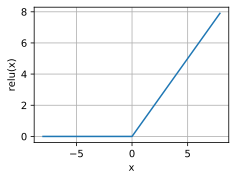

In [2]:
x = nd.arange(-8.0, 8, 0.1)
x.attach_grad()
with autograd.record():
    y = x.relu()
d2l.plot(x,y,'x','relu(x)')

When the input is negative, the derivative of ReLU function is 0 and when the input is positive, the derivative of ReLU function is 1. Note that the ReLU function is not differentiable when the input value takes value precisely equal to 0. Because the input might never be 0, we can get away by consider the derivative of ReLU at 0 is its left-hand-side derivative, which is 0.

Old adage, if subtle boundary conditions matter, we are probably doing mathematics not engineering.

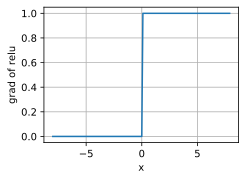

In [3]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of relu')

A variant of ReLU is pReLU by [He et al.,2015](https://arxiv.org/abs/1502.01852)

$$ \text{pReLU}(x) = \text{max}(0, x) + \alpha \text{min}(0, x) $$

## Sigmoid Function

The sigmoid function transforms its inputs which take values in $\mathbb{R}$ to the interval (0,1). For that reason, the sigmoid is often called a *squashin* function: it squashes any input in the range (-inf, inf) to some value in the range (0, 1)

$$ \text{sigmoid}(x) = \frac{1}{1 + \text{exp}(-x)} $$

When attention shifted to gradient based learning, the sigmoid function was a natural choice because it is a smooth, differentiable approximation to a thresholding unit. Sigmoids are still common as activation functions on the output units, when we want to interpret the outputs as probabilities for binary classification problems (special case of softmax). But the sigmoid has been replaced by the simpler and easier to train ReLU for most use in hidden layers.

Below are graphs of sigmoid function and its derivatives

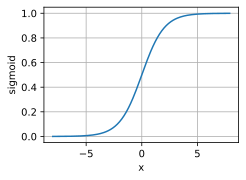

In [4]:
with autograd.record():
    y = x.sigmoid()
d2l.plot(x, y, 'x', 'sigmoid')

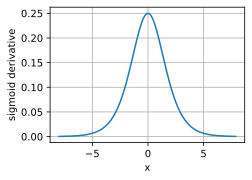

In [5]:
y.backward()
d2l.plot(x, x.grad, 'x', 'sigmoid derivative')

## Tanh Function

Like the sigmoid function, the tanh (Hyperbolic Tangent) function also squashes its inputs transforms them into elements on the interval between -1 and 1:

$$ \text{tanh}(x) = \frac{1 - \text{exp}(-2x)}{1 + \text{exp}(-2x)} $$

The graph of tanh and its derivative is as following

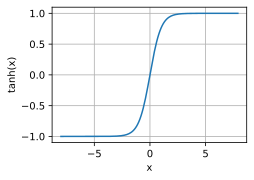

In [6]:
with autograd.record():
    y = x.tanh()
d2l.plot(x, y, 'x', 'tanh(x)')

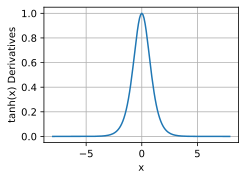

In [7]:
y.backward()
d2l.plot(x, x.grad, 'x', 'tanh(x) Derivatives')

# Implementation of MLP from scratch

We could implement MLP easily with supports of neural net and auto gradient from mxnet.

In [8]:
import d2l
from mxnet import autograd, nd, gluon

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initialize model parameters

Next we initialize model parameters. Because each image has size 28x28, our input layer will have 784 nodes. Hidden layers nodes number are chosen as power of 2 to fit into the memory.

In [9]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens))
b1 = nd.zeros(num_hiddens)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens, num_outputs))
b2 = nd.zeros(num_outputs)
params = [W1,b1,W2,b2]

for param in params:
    param.attach_grad()

## Model Implementation

Our model is quite straightforward to implement. We first stretch the whole 28x28 image into a long array size (1,784)
and feed it to a neural network. We are going to use **softmax** activation function provided by mxnet because we already know how to implement it. The **softmax** from mxnet is also numerically stable.

We will try to implement **ReLU function** by ourselves, though nd support relu function

In [10]:
def relu(X):
    return nd.maximum(X, 0)

def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(nd.dot(X,W1)+b1)
    return nd.dot(H,W2) + b2

In [11]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

## Training

We perform training by looping through the whole dataset epoch time, gradually update the parameter W

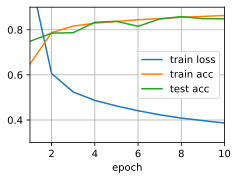

In [12]:
num_epochs, lr = 10, 0.1

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
              lambda batch_size: d2l.sgd(params, lr, batch_size))

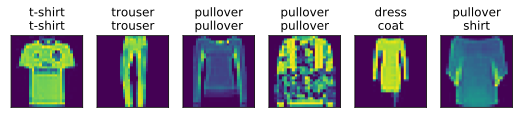

In [13]:
d2l.predict_ch3(net, test_iter)

# Concise implementation of Multilayer Perceptron

We could implement the same network using support from mxnet

In [14]:
import d2l
from mxnet import gluon, init
from mxnet.gluon import nn

The implementation is similar to softmax implementation. We add one more hidden layer with activation **ReLU** and size 256 nodes. Gluon will automatically infer the size of inputs, so we don't need to add the first layer.

In [15]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'), nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

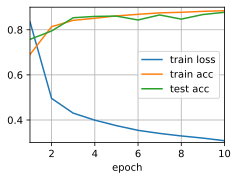

In [16]:
batch_size, num_epochs = 256, 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)